In [20]:
!nvidia-smi

Sun May  1 20:50:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |    683MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
!git clone https://github.com/bartsvoboda/NetworksTimeSeries.git

fatal: destination path 'NetworksTimeSeries' already exists and is not an empty directory.


In [22]:
import numpy as np
import pandas as pd 

#functions
def split_test_train(dataset_df):
  train_size = int(len(dataset_df) * 0.7)
  test_size = len(dataset_df) - train_size
  train, test = dataset_df.iloc[0:train_size], dataset_df.iloc[train_size:len(dataset_df)]
  return train,test 

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

#load all datasets 
dataset_I = np.load("/content/NetworksTimeSeries/datasets/dataset_5_12.npy")
dataset_II = np.load("/content/NetworksTimeSeries/datasets/dataset_5_8.npy")
dataset_III = np.load("/content/NetworksTimeSeries/datasets/dataset_8_12.npy")
dataset_IV = np.load("/content/NetworksTimeSeries/datasets/dataset_8_5.npy")

dataset_list_np = [dataset_I, dataset_II,dataset_III,dataset_IV]

time = np.arange(0, 20000)

#create df datasets 
datasets_list_df = []
for i in range(len(dataset_list_np)):
  df_temp = pd.DataFrame(dict(traffic = dataset_list_np[i]),
                         index=time, columns = ["traffic"])
  datasets_list_df.append(df_temp)                         

# test train split for all datasets
train_data = []
test_data = []
for i in range(len(datasets_list_df)):
  train_temp, test_temp = split_test_train(datasets_list_df[i])
  train_data.append(train_temp)
  test_data.append(test_temp)


## Preprocessing and load Data

In [23]:
TIME_STEPS = 10

X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for i in range(4):
  X_train_temp, y_train_temp = create_dataset(train_data[i],
                                              train_data[i].traffic,
                                              TIME_STEPS)

  X_test_temp, y_test_temp = create_dataset(test_data[i],
                                            test_data[i].traffic,
                                            TIME_STEPS)
  X_train_list.append(X_train_temp)
  X_test_list.append(X_test_temp)
  y_train_list.append(y_train_temp)
  y_test_list.append(y_test_temp)

### LSTM

In [24]:
import tensorflow as tf
from tensorflow import keras 
def fit_model_LSTM(X_train, y_train, X_test, y_test):
  tf.random.set_seed(42)

  model = keras.Sequential()
  model.add(keras.layers.LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(keras.layers.Dense(1))

  model.compile(loss='mae',
                optimizer=keras.optimizers.Adam())
  
  history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    shuffle=False)
  return model, history


In [25]:
models_list = []
histories_list = []
for i in range(4):
  model_temp, history_temp = fit_model_LSTM(X_train = X_train_list[i],
                                            y_train = y_train_list[i],
                                            X_test = X_test_list[i],
                                            y_test = y_test_list[i])
  models_list.append(model_temp)
  histories_list.append(history_temp)

### LSTM PLOTS

In [26]:
import matplotlib.pyplot as plt
def plot_losses(history):
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend();

In [27]:
def plot_results(y_train, y_test, y_pred, node_name):
  plt.figure(figsize=(10, 7))
  plt.plot(np.arange(0, len(y_train)), y_train, 'b', label="history")
  plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker=".", label="True labels")
  plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="Predictions")
  plt.ylabel("Traffic")
  plt.xlabel("Time Stamp")
  plt.title(f"{node_name}")
  plt.legend()
  plt.show();

In [28]:
y_pred_list = []

for i in range(4):
  y_pred_temp = models_list[i].predict(X_test_list[i])
  y_pred_list.append(y_pred_temp)

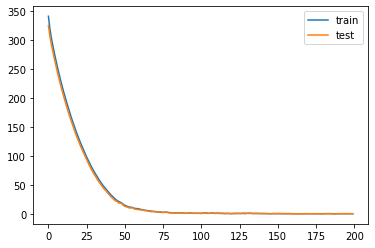

In [29]:
plot_losses(histories_list[0])

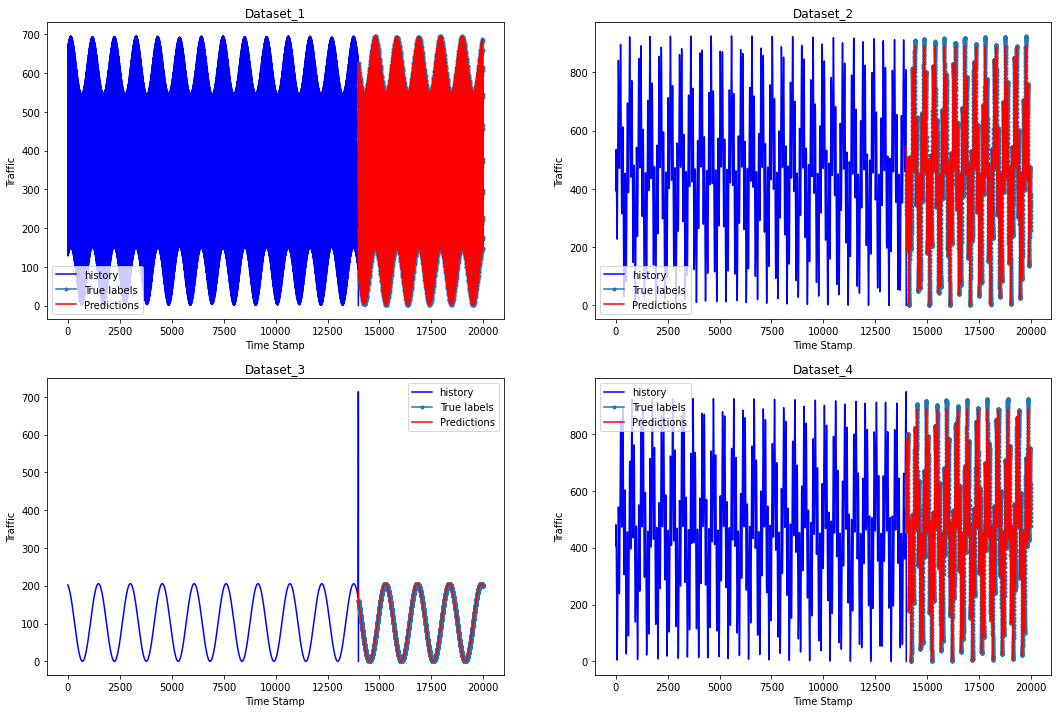

In [30]:
plt.figure(figsize=[18, 12])
for i in range(0,4):
  plt.subplot(2,2, i+1)
  plt.plot(np.arange(0, len(y_train_list[i])), y_train_list[i], 'b', label="history")
  plt.plot(np.arange(len(y_train_list[i]), len(y_train_list[i]) + len(y_test_list[i])), y_test_list[i], marker=".", label="True labels")
  plt.plot(np.arange(len(y_train_list[i]), len(y_train_list[i]) + len(y_test_list[i])), y_pred_list[i], 'r', label="Predictions")
  plt.ylabel("Traffic")
  plt.xlabel("Time Stamp")
  plt.title(f"Dataset_{i+1}")
  plt.legend()
plt.show()

In [31]:
models_list[0].summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256)               264192    
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [32]:
from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.metrics import mean_absolute_error
def calc_mape(y_pred_l, y_test_l):
  mape_list= np.zeros(shape=(4),dtype=np.float32)
  for i in range(4):
    mape_list[i] = mean_absolute_percentage_error(y_true=y_test_l[i], y_pred=y_pred_l[i])
    # mape_list[i] = mean_absolute_error(y_true=y_test_l[i], y_pred=y_pred_l[i])

  
  dict_mape_res= {
      "Data_I": mape_list[0], 
      "Data_II": mape_list[1] ,
      "Data_III": mape_list[2] ,
      "Data_IV": mape_list[3],
  }
  return dict_mape_res

In [33]:
calc_mape(y_pred_list, y_test_list)

{'Data_I': 0.009682874,
 'Data_II': 0.0032361178,
 'Data_III': 0.09895918,
 'Data_IV': 0.0024358504}

### Polynomial

In [34]:
import matplotlib.pyplot as plt

def plot_results_plynomial(y_train, y_test, y_pred, node_name):
  #plt.figure(figsize=(10, 7))
  plt.plot(np.arange(0, len(y_train)), y_train, 'b', label="history")
  plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker=".", label="True labels")
  plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="Predictions")
  plt.ylabel("Traffic")
  plt.xlabel("Time Stamp")
  plt.title(f"{node_name}")
  plt.legend()
  #plt.show();

In [35]:
np.squeeze(X_test_list[i]).shape

(5990, 10)

In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# parameters = {'n_estimators':[3, 5, 10, 15, 20, 50]}
N_ESTIMATORS = 10

models_list_pl = []
for i in range(4):
  rf_temp = RandomForestRegressor(n_estimators=N_ESTIMATORS)
  rf_temp.fit(np.squeeze(X_test_list[i]), np.squeeze(y_test_list[i]))
#   model_temp = GridSearchCV(rf, parameters)  
#   model_temp.fit(X_train[i].reshape(-1,1), y_train[i])
  models_list_pl.append(rf_temp)

In [37]:
y_pred_list_pl = []

for i in range(4):
  y_pred_temp = models_list_pl[i].predict(np.squeeze(X_test_list[i]))
  y_pred_list_pl.append(y_pred_temp)

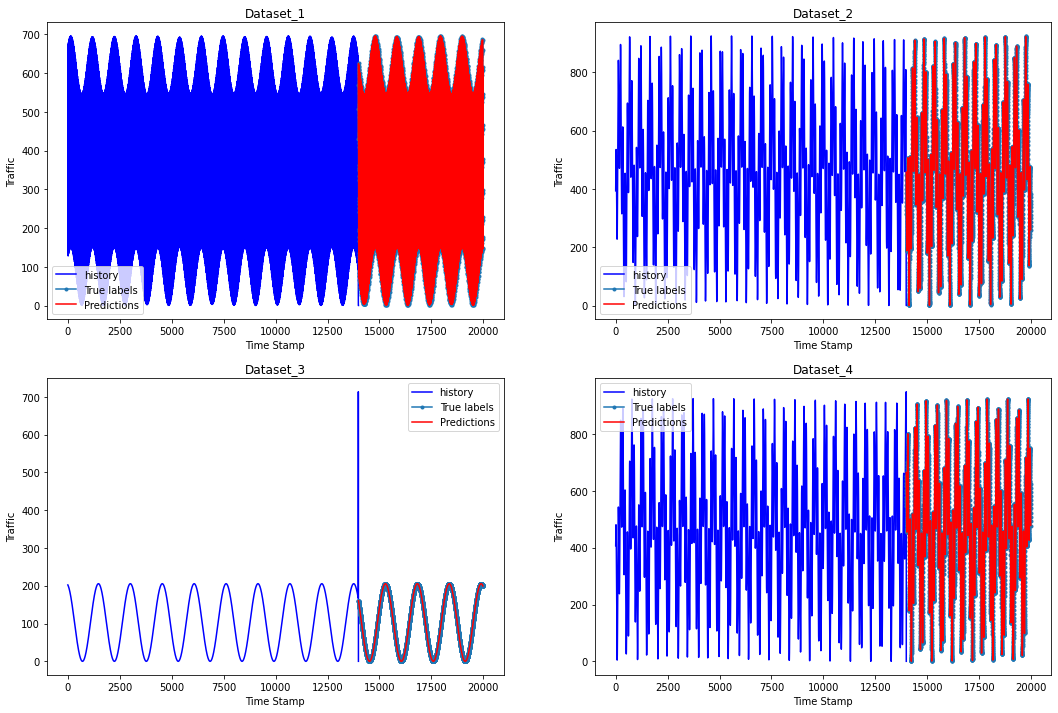

In [38]:
plt.figure(figsize=[18, 12])
for i in range(0,4):
  plt.subplot(2,2, i+1)
  plt.plot(np.arange(0, len(y_train_list[i])), y_train_list[i], 'b', label="history")
  plt.plot(np.arange(len(y_train_list[i]), len(y_train_list[i]) + len(y_test_list[i])), y_test_list[i], marker=".", label="True labels")
  plt.plot(np.arange(len(y_train_list[i]), len(y_train_list[i]) + len(y_test_list[i])), y_pred_list_pl[i], 'r', label="Predictions")
  plt.ylabel("Traffic")
  plt.xlabel("Time Stamp")
  plt.title(f"Dataset_{i+1}")
  plt.legend()
plt.show()

In [39]:
calc_mape(y_pred_list_pl, y_test_list)

{'Data_I': 0.008022448,
 'Data_II': 0.0042402428,
 'Data_III': 0.0063614175,
 'Data_IV': 0.0029498923}